# Implementation of a classifier based on a grid-based clustering algorithm
Here we are implementing a classifier based on a grid-based clustering algorithm called *clique algorithm*.

In [1]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from pyclustering.cluster.clique import clique

## Clique Algorithm
The `pyclustering` library provides the implementation of Clique. However, it does not offer any **predict** function to be used in a **classification problem**; therefore, I implemented a wrapper that contains a predict function. The predict function required two things:

1. Recognizing the category(cluster) of given input(x) in that specific clustering model
The clique algorithm will divide the space into a number of grids, which are based on the interval argument of the model; These grids are called **cells**. The `__contains__` function implemented for these cells will tell us whether a specific coordinate belongs to them or not. Unfortunately, this part might be time-consuming, especially if the number of cells is high.

This library will not give us the information about what category cell's points belong to, so I labeled all cells by checking one of its points' cluster and labeling the whole cell with that cluster's label. This is true because, actually, this algorithm categorizes all of one grid's data into one cluster. Additionally, those cells whose points did not belong to any cluster are considered noise and will inherit the label of the noise cluster.

2. Labeling clusters with true categories(y)
Every cluster will be labeled to the actual label of the majority of its points. The noise cluster is not exceptional.

In [2]:
class CliqueBasedClassifier:
    def __init__(self, intervals, threshold):
        self.__intervals = intervals
        self.__threshold = threshold
    
    def __label_cluster(self, cluster):
        labels = dict({})
        for index in cluster:
            label = self.y[index]
            if labels.get(label):
                labels[label] += 1
            else:
                labels[label] = 1
        return max(labels, key=labels.get)
    
    def __label_clusters(self):
        self.__cluster_labels = []
        for cluster in self.__clusters:
            self.__cluster_labels.append(self.__label_cluster(cluster))
        if (len(self.__noise)) > 0:
            self.__noise_label = self.__label_cluster(self.__noise)
        else:
            self.__noise_label = self.__cluster_labels[0]
            
    def __single_predict(self, x):
        for index, cell in enumerate(self.__cells):
            if x in cell.spatial_location:
                return self.__cell_labels[index]
        return self.__noise_label
    
    def __label_cells(self):
        self.__cell_labels = []
        for cell in self.__cells:
            example_point = cell.points
            for index, cluster in enumerate(self.__clusters):
                if example_point in cluster:
                    self.__cell_labels.append(self.__cluster_labels[index])
            self.__cell_labels.append(self.__noise_label)
    
    def fit(self, X, y):
        self.X = X
        self.y = y
        self.__clique_instance = clique(list(X), self.__intervals, self.__threshold)
        self.__clique_instance.process()
        self.__clusters = self.__clique_instance.get_clusters()
        self.__noise = self.__clique_instance.get_noise()
        self.__cells = self.__clique_instance.get_cells()
        self.__label_clusters()
        self.__label_cells()
        return self
    
    def predict(self, X):
        pred = []
        for x in X:
            pred.append(self.__single_predict(x))
        return pred

## Data

In [3]:
adult = pd.read_csv('./adult_data.csv', index_col=False, sep=", ", engine='python')
adult

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,<=50K
48838,64,?,321403,HS-grad,9,Widowed,?,Other-relative,Black,Male,0,0,40,United-States,<=50K
48839,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,<=50K
48840,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,<=50K


In [4]:
start_time = time.time()

In [5]:
le = preprocessing.LabelEncoder()

adult['income'] = le.fit_transform(adult['income'])

Because this model does not accept categorical data and high dimensionality will cause a lack of memory, we drop these columns. Also, for having equal influence among all dimensions, we scale all columns to 0-1.

In [6]:
X = adult.drop(['fnlwgt', 'education', 'income', 'workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country'], axis=1)
x = X.values  # returns adimensionality numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
X_scaled = pd.DataFrame(x_scaled)
Y = adult['income']

## Streaming
Because we have considered that our data is streaming, based on the paper, we divided our data into windows, and our model only considers the data available in that window.

In [7]:
window_size = 1000
windows = []

for i in range(0, len(X_scaled), window_size):
    start = i
    end = min(i + window_size, len(X_scaled))
    x = pd.DataFrame(X_scaled.iloc[start:end]).to_numpy()
    y = pd.DataFrame(Y.iloc[start:end]).to_numpy().reshape(end-start,)
    windows.append((x,y))

## Model
Here you could see the instruction for the model. `intervals` is responsible for the number of grids, and after several trials, I understood that in this problem, we do not need high `intervals`(lots of grids). `threshold` specifies outlier and non-outlier cells. In this problem, clusters where widespread and low `threshold` worked as well as a high one.

In [8]:
intervals = 5  # defines amount of cells in grid in each dimension
threshold = 4   # lets consider each point as non-outlier
accuracies_train = []
accuracies_test = []
n_samples_train = 0
n_samples_test = 0

In [9]:
for index, (X,y) in enumerate(windows):
    print("***************", index + 1, "***************")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.33, random_state=42)
    model = CliqueBasedClassifier(intervals, threshold)
    
    model = model.fit(X_train, y_train)
    accuracy_train = accuracy_score(y_train, model.predict(X_train))
    accuracy_test = accuracy_score(y_test, model.predict(X_test))
    accuracies_train.append(accuracy_train)
    accuracies_test.append(accuracy_test)
    n_samples_train += len(X_train)
    n_samples_test += len(X_test)
    print('train:', accuracy_train)
    print('test:', accuracy_test)

*************** 1 ***************
train: 0.7701492537313432
test: 0.7636363636363637
*************** 2 ***************
train: 0.7373134328358208
test: 0.7242424242424242
*************** 3 ***************
train: 0.7865671641791044
test: 0.7212121212121212
*************** 4 ***************
train: 0.744776119402985
test: 0.7606060606060606
*************** 5 ***************
train: 0.7402985074626866
test: 0.8090909090909091
*************** 6 ***************
train: 0.7567164179104477
test: 0.7848484848484848
*************** 7 ***************
train: 0.7895522388059701
test: 0.7363636363636363
*************** 8 ***************
train: 0.7820895522388059
test: 0.7484848484848485
*************** 9 ***************
train: 0.746268656716418
test: 0.7818181818181819
*************** 10 ***************
train: 0.7955223880597015
test: 0.7333333333333333
*************** 11 ***************
train: 0.7671641791044777
test: 0.7575757575757576
*************** 12 ***************
train: 0.7507462686567165
test

In [10]:
# Display the results
print("--- %s seconds ---" % (time.time() - start_time))
print('usage example')
print('{} samples trained'.format(n_samples_train))
print('{} samples analyzed'.format(n_samples_test))
print("performance training: {}".format(sum(accuracies_train) / len(accuracies_train)))
print("performance testing: {}".format(sum(accuracies_test) / len(accuracies_test)))

--- 150.80281853675842 seconds ---
usage example
32724 samples trained
16118 samples analyzed
performance training: 0.7601298760215424
performance testing: 0.7620337866997682


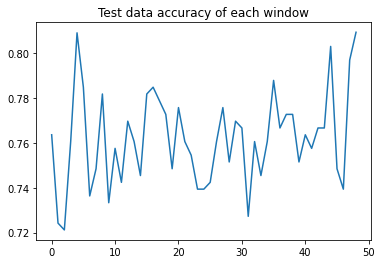

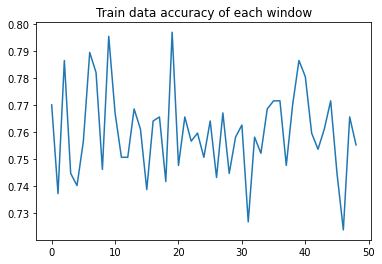

In [11]:
plt.plot(accuracies_test)
plt.title("Test data accuracy of each window")
plt.show()
plt.plot(accuracies_train)
plt.title("Train data accuracy of each window")
plt.show()

## Result
As you can see, our accuracy is a little lower than the proposed one on the paper. Also, this model did not perform well in terms of time.

## Possible Upgrades
1. Labeling clusters and cells could be done while creating them, which would benefit us in terms of time. However, it needs to develop this algorithm from scratch.
2. A better solution for recognizing the cell of a given input will have a significant impact in terms of time. This could be done by better indexing the cells.
3. Considering categorical data in our model will probably increase the accuracy.
4. Implementing a partial fit method for the clique algorithm can benefit online data. This could be done by considering a previous cell's cluster when deciding the cluster. 